<img align="right" width="300" src="https://data-services.hosting.nyu.edu/assets/libraries_short_color.png" alt="NYU Libraries Logo">

# Guidance for working with L2 political data voter files

**Overview:** The L2 Political files come in two parts for each state: Demographic indicators and Voter History. Both are .tab files (tab delimited) and will need to be extracted. It is likely that you'll need to use a command line tool to decompress each archive. 

For larger states, you will want to redact parts of these files by only loading the minimum number of variables that you need into memory, merge them together, then sample them in order to perform analysis.

This notebook is designed to provide some guidance on working with the data and creating extracts in a memory-efficient manner. It uses Python Libraries that are included with the Anacondas distribution, with the exception of [Pyjanitor](https://pyjanitor.readthedocs.io/index.html). In order to install it, run

`conda install pyjanitor -c conda-forge`

The conda distribution here seems to work the best (as opposed to pip). See the documentation for each of these libraries (especially Pandas) for more information. You will need to restart your Kernel and notebook before proceeding if you haven't already installed Pyjanitor. 

Users are expected to have agreed to the Terms of Use and should create redacted versions of the data that strip out identifying information and load only variables that are important for analysis. For the latest documentation, visit the [L2 Political LibGuide](https://guides.nyu.edu/l2political)

## I. Loading Python modules and L2 Data

Begin by importing some basic libraries to work with the data 

In [27]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#import janitor

**Loading .tab files**

First, we read in the .tab file of demographic variables, declare the tab as the separator, and set the encoding

There are 646 columns in the demographic file, and it's better to set the datetype as string (labeled "object" in Pandas) for each of them and only load certian columns to cut down on memory usage.

Declare the columns you want; see the codebook for the full list and don't take PID columns.


In [2]:
selected_variables = ['LALVOTERID',
                      'Residence_Addresses_Latitude',
                      'Residence_Addresses_Longitude',
                      'Voters_Gender',
                      'Voters_FIPS']

## Change the file path below accordingly to point toward the relevant file. Note that this data loading step below
## will take the longest out of any step for your computer to process

state_demographic = pd.read_csv('VM2--VA--2020-03-01-DEMOGRAPHIC.tab', 
                                sep='\t', dtype=str, encoding='unicode_escape',
                                usecols=selected_variables)

## Preview of the first 5 rows of the data subset. 

state_demographic.head(5)

,LALVOTERID,Residence_Addresses_Latitude,Residence_Addresses_Longitude,Voters_Gender,Voters_FIPS
0,LALVA167958824,37.901764,-75.505997,F,001
1,LALVA516951467,37.901764,-75.505997,M,001
2,LALVA462558999,37.901343,-75.566436,F,001
3,LALVA462552402,37.901343,-75.566436,M,001
4,LALVA4161517,37.807510,-75.607740,M,001


It's also not a bad idea to test the length of the entire file and verify it with the number of records on the documentation

In [3]:
len(state_demographic)

5264320

You can also run .info to get a breakdown, including how much memory the data frame is eating up.

This will give you context for how much your computer can handle.

In [4]:
state_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5264320 entries, 0 to 5264319
Data columns (total 5 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   LALVOTERID                     object
 1   Residence_Addresses_Latitude   object
 2   Residence_Addresses_Longitude  object
 3   Voters_Gender                  object
 4   Voters_FIPS                    object
dtypes: object(5)
memory usage: 200.8+ MB


Next, we will read into memory the voter history file that corresponds to the state.

This time, we make sure to include the *LALVOTERID* column, and we will add whether or not they voted in 2016.

In [5]:
needed_variables = ['LALVOTERID', 'General_2016_11_08']

state_voterhistory = pd.read_csv('VM2--VA--2020-03-01-VOTEHISTORY.tab',
                                 sep='\t', dtype=str, encoding='unicode_escape',
                                 usecols=needed_variables)
                                
state_voterhistory.head(5)

,LALVOTERID,General_2016_11_08
0,LALVA167958824,Y
1,LALVA516951467,NaN
2,LALVA462558999,Y
3,LALVA462552402,Y
4,LALVA4161517,Y


In [6]:
## Again, I will want to run an .info command to test the size and memory

state_voterhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5264320 entries, 0 to 5264319
Data columns (total 2 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   LALVOTERID          object
 1   General_2016_11_08  object
dtypes: object(2)
memory usage: 80.3+ MB


## II. Join of Demographic and Voter History Tables

Now that I have established a two reduced tables with a connection, I can join them (using the merge method in Pandas) based on the *LALVOTERID* common key


In [7]:
merged_file = pd.merge(state_voterhistory, state_demographic,
                       how='left', left_on='LALVOTERID', right_on='LALVOTERID')

merged_file.head(5)

,LALVOTERID,General_2016_11_08,Residence_Addresses_Latitude,Residence_Addresses_Longitude,Voters_Gender,Voters_FIPS
0,LALVA167958824,Y,37.901764,-75.505997,F,001
1,LALVA516951467,NaN,37.901764,-75.505997,M,001
2,LALVA462558999,Y,37.901343,-75.566436,F,001
3,LALVA462552402,Y,37.901343,-75.566436,M,001
4,LALVA4161517,Y,37.807510,-75.607740,M,001


## III. Sampling the Records

From here, you can sample the records. The frac argument is in percentage, so here, it's a one percent sample note that the sample function also guesses the dtype (which is proccess intensive) so it's better to do the sample after the final merge

In [8]:
state_sample = merged_file.sample(frac=0.01)

state_sample.head(5)

,LALVOTERID,General_2016_11_08,Residence_Addresses_Latitude,Residence_Addresses_Longitude,Voters_Gender,Voters_FIPS
4506497,LALVA4381855,Y,36.861190,-76.266420,F,710
3220820,LALVA1954212,Y,37.228351,-79.976485,M,161
745576,LALVA738960,Y,37.509310,-77.649680,M,041
2152787,LALVA471745169,Y,36.985720,-76.612630,M,093
3196996,LALVA398865370,NaN,37.241560,-79.995220,M,161


Again, print out the info to see that its a valid sample size (actually one percent) and that it is using much less memory

You'll know that the sampling worked if the index numbers are nonsequential and random also, you can test the length and info of your new sample

In [9]:
state_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52643 entries, 4506497 to 2917779
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   LALVOTERID                     52643 non-null  object
 1   General_2016_11_08             36531 non-null  object
 2   Residence_Addresses_Latitude   52639 non-null  object
 3   Residence_Addresses_Longitude  52639 non-null  object
 4   Voters_Gender                  52643 non-null  object
 5   Voters_FIPS                    52643 non-null  object
dtypes: object(6)
memory usage: 2.8+ MB


## IV. Further Deidentifying Geocoded Locations: Jittering

There are many other filtering and cleaning steps to be taken before writing out a new file

For example, the coordinates can be identifying, even if you strip out all of the other PID variables, because they are geocoded to the address. You will want to jitter them if you intend to aggregate or visualize data.

First, print out the data types to make sure what they are:

In [10]:
state_sample.dtypes

LALVOTERID                       object
General_2016_11_08               object
Residence_Addresses_Latitude     object
Residence_Addresses_Longitude    object
Voters_Gender                    object
Voters_FIPS                      object
dtype: object

In [11]:
## In order to jitter the coordinates, you need to change them to a float

state_sample['Residence_Addresses_Latitude'] = pd.to_numeric(state_sample['Residence_Addresses_Latitude']) 
state_sample['Residence_Addresses_Longitude'] = pd.to_numeric(state_sample['Residence_Addresses_Longitude']) 

state_sample.dtypes

LALVOTERID                        object
General_2016_11_08                object
Residence_Addresses_Latitude     float64
Residence_Addresses_Longitude    float64
Voters_Gender                     object
Voters_FIPS                       object
dtype: object

The module pyjanitor introduces a jitter method for dataframes that can be used to displace the exact coordinates of a location.

We'll start with jittering the latitude. This library inserts a Gaussian distribution ("noise") equal to the standard deviation of the scale. The exact amount of the scale in jitter may need to change but this is a good starting place. You may want to test the results in a mapping software like QGIS or ArcMap before proceeding too far

In [12]:
jittered_lat = state_sample.jitter(
    column_name='Residence_Addresses_Latitude',
    dest_column_name='lat_jitter',
    scale=0.05,
    clip=None,
    random_state=None,
)

jittered_lat.head(5)

,LALVOTERID,General_2016_11_08,Residence_Addresses_Latitude,Residence_Addresses_Longitude,Voters_Gender,Voters_FIPS,lat_jitter
4506497,LALVA4381855,Y,36.861190,-76.266420,F,710,36.810290
3220820,LALVA1954212,Y,37.228351,-79.976485,M,161,37.255338
745576,LALVA738960,Y,37.509310,-77.649680,M,041,37.505897
2152787,LALVA471745169,Y,36.985720,-76.612630,M,093,36.955577
3196996,LALVA398865370,NaN,37.241560,-79.995220,M,161,37.181218


In [13]:
## Now we jitter the longitude

jittered_long = state_sample.jitter(
    column_name='Residence_Addresses_Longitude',
    dest_column_name='long_jitter',
    scale=0.05,
    clip=None,
    random_state=None,
)

jittered_long.head(5)

,LALVOTERID,General_2016_11_08,Residence_Addresses_Latitude,Residence_Addresses_Longitude,Voters_Gender,Voters_FIPS,lat_jitter,long_jitter
4506497,LALVA4381855,Y,36.861190,-76.266420,F,710,36.810290,-76.255566
3220820,LALVA1954212,Y,37.228351,-79.976485,M,161,37.255338,-80.044706
745576,LALVA738960,Y,37.509310,-77.649680,M,041,37.505897,-77.576737
2152787,LALVA471745169,Y,36.985720,-76.612630,M,093,36.955577,-76.638565
3196996,LALVA398865370,NaN,37.241560,-79.995220,M,161,37.181218,-79.913420


To complete the jittering process, make sure you drop off the actual Residence_Addresses columns.

With this last dataframe, you should have a one percent sample that has jittered lat long coordinates, voter gender, whether or not they voted in 2016, and their unique ID:


In [14]:
stripped_sample = jittered_long.drop(columns=['Residence_Addresses_Latitude', 'Residence_Addresses_Longitude'])

stripped_sample.head(5)

,LALVOTERID,General_2016_11_08,Voters_Gender,Voters_FIPS,lat_jitter,long_jitter
4506497,LALVA4381855,Y,F,710,36.810290,-76.255566
3220820,LALVA1954212,Y,M,161,37.255338,-80.044706
745576,LALVA738960,Y,M,041,37.505897,-77.576737
2152787,LALVA471745169,Y,M,093,36.955577,-76.638565
3196996,LALVA398865370,NaN,M,161,37.181218,-79.913420


## V. Saving the Resulting Dataframe to a CSV

Finally, you may want to write out the sample to a CSV, leaving out the index that Pandas creates and stipulating the encoding into utf-8

In [ ]:
stripped_sample.to_csv(r'virginia-onepercent-sample.csv', index=False, encoding='utf-8')

In the course of your analysis, you may want to repeat this process for multiple states and/or develop an aggregate roster of voters culled from a subset. You are encouraged to visit the tools section on the [L2 Political LibGuide at NYU Libraries](https://guides.nyu.edu/l2political/tools).

In general, you should have a data management plan with these files that includes the following elements:

- Secure any original .tab files you've downloaded by storing them in a single directory location, and then deleting the original .tab files once you've generated extracts
- Manage your extracted samples in a secure environment

Simple scripts and suggestions are available on the L2 Political LibGuide. 


## Saahil Test
### Dropping Private/Redundant columns

In [2]:
state_demographic_ak = pd.read_csv(r'C:\Users\saahi\Desktop\VM2--AK--2020-03-18-DEMOGRAPHIC.tab', 
                                sep='\t', dtype=str, encoding='unicode_escape')

In [3]:
def drop_private(df):
    # list of all columns that contain private information
    private_cols = ['VoterTelephones_Landline7Digit'
                    ,'VoterTelephones_LandlineUnformatted'
                    ,'VoterTelephones_CellPhoneFormatted'
                    ,'VoterTelephones_CellPhoneUnformatted'
                    ,'Voters_FirstName'
                    ,'Voters_MiddleName'
                    ,'Voters_LastName'
                    ,'Voters_NameSuffix'
                    ,'Residence_Addresses_AddressLine'
                    ,'Residence_Addresses_ExtraAddressLine'
                    ,'Residence_Addresses_ZipPlus4'
                    ,'Residence_Addresses_HouseNumber'
                    ,'Residence_Addresses_PrefixDirection'
                    ,'Residence_Addresses_StreetName'
                    ,'Residence_Addresses_Designator'
                    ,'Residence_Addresses_SuffixDirection'
                    ,'Residence_Addresses_ApartmentNum'
                    ,'Residence_Families_FamilyID'
                    ,'Mailing_Addresses_AddressLine'
                    ,'Mailing_Addresses_ExtraAddressLine'
                    ,'Mailing_Addresses_HouseNumber'
                    ,'Mailing_Addresses_PrefixDirection'
                    ,'Mailing_Addresses_StreetName'
                    ,'Mailing_Addresses_Designator'
                    ,'Mailing_Addresses_SuffixDirection'
                    ,'Mailing_Addresses_ApartmentNum'
                    ,'Mailing_Families_FamilyID'
                    ,'Voters_BirthDate'
                    ,'Residence_Addresses_City'
                    ,'DateConfidence_Description'
                    ,'Precinct'
                    ,'VoterTelephones_LandlineAreaCode'
                    ,'Residence_Addresses_State' 
                    ,'Residence_Addresses_LatLongAccuracy']
    
    indices_to_drop = []
    # getting the indices for columns containing private information
    for i in range(df.shape[1]):
        for j in range(len(private_cols)):
            if private_cols[j] == df.columns[i]:
                indices_to_drop.append(i)
    
    # dropping the relevant columns            
    df.drop(df.columns[indices_to_drop], axis = 1, inplace = True)
    
    return df

In [4]:
data = drop_private(state_demographic_ak)
data.shape[1]

612

### Threshold

In [5]:
def data_threshold(df):
    # Dropping all columns that have 75% or more null values
    dt = int(0.75*df.shape[0])
    df.dropna(axis=1, thresh=dt, inplace=True)
    return df

In [6]:
data = data_threshold(data)
data.shape[1]

195

In [7]:
# print(data.columns.values)
test_data  = data.copy()

## Cleaning Data
#### Data-type for all columns is 'object'. The following method converts all possible columns to numeric

In [8]:
# Function converts the obvious numeric columns into int/float
def prelim_numeric_converter(df):
    df.loc[:, df.columns.str.startswith('Commercial')] = df.loc[:, df.columns.str.startswith('Commercial')].replace(["$"], "", regex=True)
    cols = df.columns
    for c in cols:
        try:
            df[c] = pd.to_numeric(df[c])
        except:
            pass
    return df

In [16]:
data = prelim_numeric_converter(data)

#### The following methods, while resource heavy, relpace '\%' with "" for columns on Election Data:

In [10]:
# converting election results to numeric (resource heavy)
def election_numeric_converter(df):
    col_len = df.shape[1]-1
    df.loc[:, df.columns.str.startswith('Election')] = df.loc[:, df.columns.str.startswith('Election')].replace(["%"], "", regex=True)
    for i in range(df.loc[:, df.columns.str.startswith('Election')].shape[1]):
        try:
            df.iloc[:, col_len-i] = pd.to_numeric(df.iloc[:, col_len-i])
        except:
            pass
    return df

In [17]:
data = election_numeric_converter(data)

In [18]:
data.dtypes.value_counts()

float64    117
int64       49
object      29
dtype: int64

In [14]:
data['ElectionReturns_P18PrecinctTurnoutRepublicans']
#data.head(10)

0         26.0
1         26.0
2         26.0
3         26.0
4         26.0
          ... 
522488    26.0
522489    26.0
522490    26.0
522491    26.0
522492    26.0
Name: ElectionReturns_P18PrecinctTurnoutRepublicans, Length: 522493, dtype: float64

In [19]:
test_data_converted = data.copy()

## Imputation using Machine Learning

### Converting Binary to 1 & 0 
#### Can't figure out what NaN values are 0 and what are empty so Im just gonna not impute values for them

In [98]:
# to re-initiate the smaller, numeric dataset
data = test_data_converted.copy()

In [142]:
# run after dropping personal data and threshold
def knn_imputation(df):
    binary = []
    # Getting the indices for columns that are binary
    for i in range(df.shape[1]):
        if (df.iloc[ : , i].isnull().values.any()):
            if (len(df.iloc[ : , i].value_counts()) == 1):
                binary.append(i)
    # Temporarily drop binary columns 
    temp_data_1 = data.columns[binary].copy()            
    data.drop(data.columns[binary], axis = 1, inplace = True)
    
    imputer = IterativeImputer()
    imputer.fit(data)
    Xtrans = imputer.transform(data)

### PCA for Election Results

In [20]:
def drop_binary(df):    
    binary = []
    # Getting the indices for columns that are binary
    for i in range(df.shape[1]):
        if (df.iloc[ : , i].isnull().values.any()):
            if (len(df.iloc[ : , i].value_counts()) == 1):
                binary.append(i)
    df.drop(df.columns[binary], axis = 1, inplace = True)
    return df

In [60]:
# Plotting the cumulative explained variance to determine the required covariates
def pca_plot(df):
    df = df.select_dtypes(exclude=['object']).copy()
    df = drop_binary(df)
    df.fillna(0, inplace=True)
    pca = PCA().fit(df)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.xlim([0, 25])
    plt.grid()
    plt.grid(which='minor', alpha=0.2)
    plt.grid(which='major', alpha=0.7)
    plt.minorticks_on()
    plt.title("Cumulative explained variance vs. Number of Covariates")

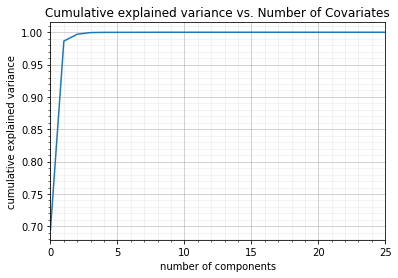

In [61]:
pca_plot(data)

In [103]:
def knn_imputation(df):
    df = df.select_dtypes(exclude=['object']).copy()
    df = drop_binary(df)
    df.head()
    imputer = KNNImputer(n_neighbors = int((df.shape[0]**(1/2))/2))
    imputer.fit_transform(df)

In [95]:
data.head()

,SEQUENCE,LALVOTERID,Voters_Active,Voters_StateVoterID,Residence_Addresses_Zip,Residence_Addresses_CassErrStatCode,Voters_SequenceZigZag,Voters_SequenceOddEven,Residence_Addresses_CensusTract,Residence_Addresses_CensusBlockGroup,...,ElectionReturns_P16CountyTurnoutRepublicans,ElectionReturns_P16PrecinctTurnoutAllRegisteredVoters,ElectionReturns_P16PrecinctTurnoutDemocrats,ElectionReturns_P16PrecinctTurnoutRepublicans,ElectionReturns_P18CountyTurnoutAllRegisteredVoters,ElectionReturns_P18CountyTurnoutDemocrats,ElectionReturns_P18CountyTurnoutRepublicans,ElectionReturns_P18PrecinctTurnoutAllRegisteredVoters,ElectionReturns_P18PrecinctTurnoutDemocrats,ElectionReturns_P18PrecinctTurnoutRepublicans
0,1,LALAK410126890,A,1135871,99553.0,E412,0,0,100.0,1.0,...,28,36.0,41.0,38.0,17,20,22,19.0,19.0,26.0
1,2,LALAK504532417,A,1230757,99553.0,E421,1,1,100.0,1.0,...,28,36.0,41.0,38.0,17,20,22,19.0,19.0,26.0
2,3,LALAK177113938,A,994519,99553.0,E412,2,2,NaN,NaN,...,28,36.0,41.0,38.0,17,20,22,19.0,19.0,26.0
3,4,LALAK177127696,A,994764,99553.0,E412,3,3,NaN,NaN,...,28,36.0,41.0,38.0,17,20,22,19.0,19.0,26.0
4,5,LALAK470911183,A,1202491,99553.0,E412,4,4,100.0,1.0,...,28,36.0,41.0,38.0,17,20,22,19.0,19.0,26.0


In [ ]:
pca

In [75]:
data.select_dtypes(exclude=['object']).dtypes

SEQUENCE                                                   int64
Voters_StateVoterID                                        int64
Residence_Addresses_Zip                                  float64
Voters_SequenceZigZag                                      int64
Voters_SequenceOddEven                                     int64
                                                          ...   
ElectionReturns_P18CountyTurnoutDemocrats                  int64
ElectionReturns_P18CountyTurnoutRepublicans                int64
ElectionReturns_P18PrecinctTurnoutAllRegisteredVoters    float64
ElectionReturns_P18PrecinctTurnoutDemocrats              float64
ElectionReturns_P18PrecinctTurnoutRepublicans            float64
Length: 138, dtype: object

In [59]:
for keys in place_dic.keys():
    
    for j in range(len(private_cols)):
        if key == private_cols[j]:
            

        
if place_dic[key].drop(private_cols)

SyntaxError: unexpected EOF while parsing (<ipython-input-59-17fa494f8809>, line 2)

In [62]:
 for i in range(df.shape[1]):
        for j in range(len(private_cols)):
            if private_cols[j] == df.columns[i]:
                indices_to_drop.append(i)

NameError: name 'df' is not defined

In [67]:
print(data.columns.values)

['SEQUENCE' 'LALVOTERID' 'Voters_Active' 'Voters_StateVoterID'
 'Residence_Addresses_Zip' 'Residence_Addresses_CassErrStatCode'
 'Voters_SequenceZigZag' 'Voters_SequenceOddEven'
 'Residence_Addresses_CensusTract' 'Residence_Addresses_CensusBlockGroup'
 'Residence_Addresses_CensusBlock' 'Residence_Addresses_Latitude'
 'Residence_Addresses_Longitude' 'Residence_Addresses_Density'
 'Residence_Families_HHCount' 'Residence_HHGender_Description'
 'Residence_HHParties_Description' 'Mailing_Addresses_City'
 'Mailing_Addresses_State' 'Mailing_Addresses_Zip'
 'Mailing_Addresses_ZipPlus4' 'Mailing_Addresses_CassErrStatCode'
 'Mailing_Families_HHCount' 'Mailing_HHGender_Description'
 'Mailing_HHParties_Description' 'Voters_Gender' 'Parties_Description'
 'Ethnic_Description' 'EthnicGroups_EthnicGroup1Desc'
 'Voters_CalculatedRegDate' 'Voters_OfficialRegDate'
 'US_Congressional_District' 'AddressDistricts_Change_Changed_CD'
 'State_Senate_District' 'AddressDistricts_Change_Changed_SD'
 'State_House_

In [68]:
# DEMOGRAPHIC BREAKDOWN BY PARTY
# Aggregating by Political Party(Parties_Description): 
# Ethinicity (Ethnic_Description/EthnicGroups_EthnicGroup1Desc), 
# Gender (Voters_Gender),
# Income (CommercialData_EstimatedHHIncome)

data.groupby(['Parties_Description']).sum()

,SEQUENCE,Voters_StateVoterID,Residence_Addresses_Zip,Voters_SequenceZigZag,Voters_SequenceOddEven,Residence_Addresses_CensusTract,Residence_Addresses_CensusBlockGroup,Residence_Addresses_CensusBlock,Residence_Addresses_Latitude,Residence_Addresses_Longitude,...,ElectionReturns_P16CountyTurnoutRepublicans,ElectionReturns_P16PrecinctTurnoutAllRegisteredVoters,ElectionReturns_P16PrecinctTurnoutDemocrats,ElectionReturns_P16PrecinctTurnoutRepublicans,ElectionReturns_P18CountyTurnoutAllRegisteredVoters,ElectionReturns_P18CountyTurnoutDemocrats,ElectionReturns_P18CountyTurnoutRepublicans,ElectionReturns_P18PrecinctTurnoutAllRegisteredVoters,ElectionReturns_P18PrecinctTurnoutDemocrats,ElectionReturns_P18PrecinctTurnoutRepublicans
Parties_Description,,,,,,,,,,,,,,,,,,,,,
Constitution,136172386,552063966,5.050043e+07,136171892,136172714,461019.0,1087.0,1106855.0,3.037901e+04,-7.368547e+04,...,12914,8200.0,10113.0,11808.0,11293,13435,15798,10302.0,12559.0,14844.0
Democratic,16329055550,54514864933,6.706511e+09,16328988430,16328987031,119575687.0,146204.0,147918448.0,4.033231e+06,-9.792094e+06,...,1703424,1190124.0,1459686.0,1680137.0,1526530,1876732,2103575,1544399.0,1935949.0,2110747.0
Green Libertarian,378295564,1290531253,1.435875e+08,378294114,378292787,1411818.0,3060.0,3099518.0,8.625732e+04,-2.087600e+05,...,36121,24826.0,29776.0,35462.0,33132,40108,45638,33007.0,41257.0,45413.0
Independence,4258383865,13314416684,1.536625e+09,4258368350,4258369532,27572700.0,32199.0,32664979.0,9.292224e+05,-2.256796e+06,...,388437,266384.0,319713.0,378398.0,346511,415656,479820,340915.0,409807.0,480401.0
Libertarian,1476099716,5970995669,6.185543e+08,1476093718,1476092942,10804180.0,13873.0,14011010.0,3.758455e+05,-9.129673e+05,...,163051,104581.0,120794.0,154238.0,143684,168651,203373,137435.0,163015.0,198496.0
Non-Partisan,19343380963,54905996286,7.494387e+09,19343306189,19343319051,127263820.0,162482.0,164350515.0,4.536865e+06,-1.098487e+07,...,1912707,1346810.0,1569246.0,1925101.0,1735822,2080588,2412056,1790644.0,2155076.0,2478098.0
Other,353328308,1396088648,1.413212e+08,353326850,353326574,3220831.0,3163.0,3202003.0,8.566922e+04,-2.074551e+05,...,36378,22023.0,25583.0,32771.0,32390,38366,45540,29273.0,34572.0,42681.0
Republican,33392946598,98045600745,1.223760e+10,33392824933,33392809961,176981960.0,257223.0,260349874.0,7.418276e+06,-1.796117e+07,...,3145492,2179103.0,2432740.0,3134562.0,2850444,3311733,4007855,2911565.0,3332716.0,4113424.0
Unknown,60832065821,227082977728,2.291092e+10,60831831802,60831835686,397174245.0,487479.0,493463300.0,1.387990e+07,-3.369380e+07,...,5797881,3884574.0,4616589.0,5608056.0,5205104,6220101,7243761,5081008.0,6125089.0,7203301.0


In [78]:
# Returns aggregated demographic information for each party
def demographic_agg(df):
    try:
        df['counter'] = 1
        data = pd.crosstab(index=df['Parties_Description'], columns=[df['EthnicGroups_EthnicGroup1Desc'],df['Voters_Gender']], values=df['counter'], aggfunc='sum')
        return data
    except:
        print("Sorry, not Enough Information for a Demographic Breakdown")

In [83]:
demographic_agg(data)

EthnicGroups_EthnicGroup1Desc East and South Asian         European           \
Voters_Gender                                    F       M        F        M   
Parties_Description                                                            
Constitution                                   6.0    13.0    109.0    239.0   
Democratic                                   961.0   761.0  27826.0  19721.0   
Green Libertarian                             10.0    15.0    457.0    637.0   
Independence                                 155.0   164.0   5421.0   6185.0   
Libertarian                                   58.0    66.0   1886.0   2969.0   
Non-Partisan                                 822.0   712.0  27203.0  32124.0   
Other                                          8.0    23.0    282.0    742.0   
Republican                                  1064.0   862.0  44747.0  56173.0   
Unknown                                     3719.0  3277.0  81817.0  84764.0   

EthnicGroups_EthnicGroup1Desc Hispanic and Portuguese          \
Voters_Gender                                       F       M   
Parties_Description                                             
Constitution                                     16.0    32.0   
Democratic                                     2587.0  2191.0   
Green Libertarian                                27.0    36.0   
Independence                                    338.0   376.0   
Libertarian                                     164.0   163.0   
Non-Partisan                                   1652.0  1758.0   
Other                                            40.0    84.0   
Republican                                     2301.0  2496.0   
Unknown                                        7634.0  7197.0   

EthnicGroups_EthnicGroup1Desc Likely African-American           Other          
Voters_Gender                                       F       M       F       M  
Parties_Description                                                            
Constitution                                      2.0     NaN    10.0    12.0  
Democratic                                     1346.0  1033.0  1354.0  1133.0  
Green Libertarian                                 3.0     2.0    14.0    27.0  
Independence                                     39.0    33.0   245.0   279.0  
Libertarian                                      18.0    19.0    58.0    79.0  
Non-Partisan                                    131.0   158.0   996.0   994.0  
Other                                             3.0    10.0    19.0    38.0  
Republican                                       58.0    57.0  1134.0  1345.0  
Unknown                                         670.0   656.0  4292.0  4137.0

In [81]:
# Returns aggregated information on historical voting performance for each party 
def merged_agg(df):
    try:
        criteria = [df['VotingPerformanceEvenYearGeneral'].between(0, 25), 
                df['VotingPerformanceEvenYearGeneral'].between(26, 50), 
                df['VotingPerformanceEvenYearGeneral'].between(51, 75), 
                df['VotingPerformanceEvenYearGeneral'].between(76, 101)]
        values = ['Poor', 'Below_Average', 'Above_average', 'Excellent']

        df['general_voting_performance'] = np.select(criteria, values, "Unknown")        
        data = pd.crosstab(index=df['Parties_Description'], columns=df['general_voting_performance'], values=df['counter'], aggfunc='sum')
        return data
    except:
        print("Sorry, not Enough Information for a Voting History Breakdown")

Sorry, not enough information for a Demographic breakdown


In [82]:

pd.crosstab(index=data['Parties_Description'], columns=data['ElectionReturns_P18PrecinctTurnoutDemocrats'], values=data['ElectionReturns_P18PrecinctTurnoutDemocrats'], aggfunc='mean')

ElectionReturns_P18PrecinctTurnoutDemocrats,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,57.0,58.0,59.0,61.0,63.0,66.0,67.0,68.0,80.0,100.0
Parties_Description,,,,,,,,,,,,,,,,,,,,,
Constitution,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,67.0,68.0,NaN,NaN
Democratic,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,57.0,58.0,59.0,61.0,63.0,66.0,67.0,68.0,80.0,100.0
Green Libertarian,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,57.0,NaN,59.0,61.0,NaN,NaN,67.0,NaN,80.0,NaN
Independence,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,57.0,58.0,59.0,61.0,63.0,66.0,67.0,68.0,80.0,NaN
Libertarian,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,57.0,58.0,59.0,61.0,63.0,66.0,67.0,68.0,80.0,NaN
Non-Partisan,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,57.0,58.0,59.0,61.0,63.0,66.0,67.0,68.0,80.0,100.0
Other,0.0,1.0,3.0,4.0,5.0,NaN,7.0,NaN,9.0,11.0,...,57.0,NaN,NaN,NaN,NaN,NaN,67.0,NaN,NaN,NaN
Republican,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,57.0,58.0,59.0,61.0,63.0,66.0,67.0,68.0,80.0,NaN
Unknown,0.0,1.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,57.0,58.0,59.0,61.0,63.0,66.0,67.0,68.0,80.0,NaN


In [76]:
pd.crosstab(index=data['Parties_Description'], columns=data['CommercialData_EstimatedHHIncome'], values=data['counter'], aggfunc='mean')

CommercialData_EstimatedHHIncome,$1000-14999,$100000-124999,$125000-149999,$15000-24999,$150000-174999,$175000-199999,$200000-249999,$25000-34999,$250000+,$35000-49999,$50000-74999,$75000-99999
Parties_Description,,,,,,,,,,,,
Constitution,1,1,1,1,1,1,1,1,1,1,1,1
Democratic,1,1,1,1,1,1,1,1,1,1,1,1
Green Libertarian,1,1,1,1,1,1,1,1,1,1,1,1
Independence,1,1,1,1,1,1,1,1,1,1,1,1
Libertarian,1,1,1,1,1,1,1,1,1,1,1,1
Non-Partisan,1,1,1,1,1,1,1,1,1,1,1,1
Other,1,1,1,1,1,1,1,1,1,1,1,1
Republican,1,1,1,1,1,1,1,1,1,1,1,1
Unknown,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
VotingPerformanceEvenYearGeneral
df.loc[:, df.columns.str.startswith('VotingPerformance')] = df.loc[:, df.columns.str.startswith('VotingPerformance')].replace(["%"], "", regex=True)